<img src="escuela-de-economia.png" width="260" height="60">
<center>
    <b>EC4301 MACROECONOMETRÍA</b><br>
    <b>Profesor:  Randall Romero Aguilar, PhD</b>
<br><br>
<b>Laboratorio:</b>
<div style="font-size:175%;color:white; background-color: #0064b0;">Tema 5: Modelos para series con tendencia</div>
<div style="font-size:250%;color:white; background-color: #0064b0;">Replicando el trabajo de Granger y Newbold 1974</div> 
</center>
<i>Creado:     2020-May-01 
    <br>
    Actualizado: 2020-Oct-25</i>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
import seaborn as sns

In [3]:
from scipy.stats import t as t_Student

In [4]:
plt.style.use('seaborn')
plt.rc('figure', figsize=(15,4))
plt.rc('axes', titlesize=20, labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

# Replicating Granger y Newbold 1974
Basado en Levendis pp117-121

## Regresión de una caminata aleatoria contra otra caminata aleatoria independiente

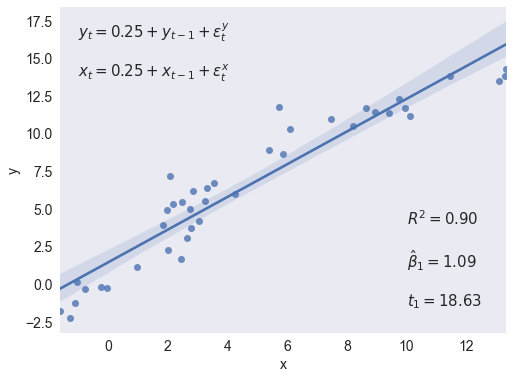

In [5]:
np.random.seed(240)
e = np.random.randn(2,40)
y, x = (0.25+e).cumsum(axis=1)
X = sm.add_constant(x)
res = sm.OLS(y, X).fit()


fig, ax = plt.subplots(figsize=[8,6])
sns.regplot(x,y,'*',ax=ax)
ax.set(xlabel='x', ylabel='y')

statslabel = f'$R^2={res.rsquared:.2f}$'
statslabel += f'\n\n$\\hat\\beta_1={res.params[1]:.2f}$'
statslabel += f'\n\n$t_1={res.tvalues[1]:.2f}$'
ax.annotate(statslabel, (10,5), size=15, va='top')


modellabel = r'$y_t = 0.25 + y_{t-1} + \epsilon^y_t$'
modellabel += '\n\n$x_t = 0.25 + x_{t-1} + \\epsilon^x_t$'
ax.annotate(modellabel, (-1,17.5), size=15, va='top')

ax.grid(False)
fig.savefig('regresion-espuria-1caso.pdf', bbox_inches='tight')

In [6]:
res.params

array([1.44456189, 1.08570021])

In [7]:
np.linalg.solve(X.T @ X, X.T @ y)

array([1.44456189, 1.08570021])

## Experimento de Monte Carlo para determinar la distribución del estadítico t

In [8]:
def regresion_estacionaria(T=100):
    y, x = np.random.randn(2,T)
    X = sm.add_constant(x)
    res = sm.OLS(y, X).fit()
    return res.tvalues[1]

In [9]:
def regresion_espuria(T=100):
    e = np.random.randn(2,T)
    y, x = e.cumsum(axis=1)
    X = sm.add_constant(x)
    res = sm.OLS(y, X).fit()
    return res.tvalues[1]

In [10]:
%%time
N = 100_000
np.random.seed(12345)
tvalues = pd.Series([regresion_estacionaria() for _ in range(N)])

np.random.seed(12345)
zvalues = pd.Series([regresion_espuria() for _ in range(N)])

Wall time: 1min 21s


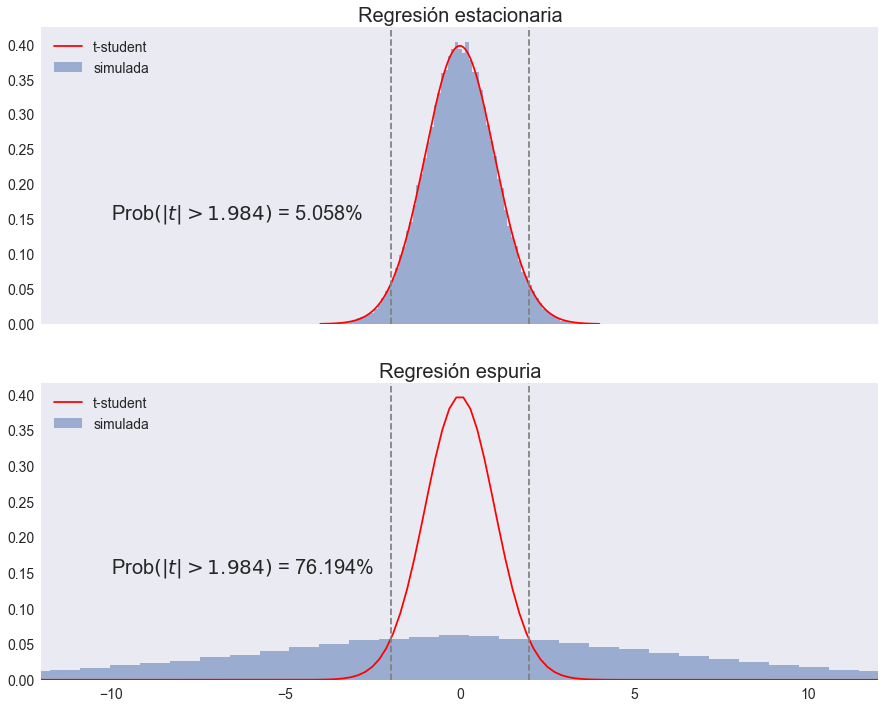

In [11]:
fig, (ax0,ax1) = plt.subplots(2,1,figsize=[15, 12], sharex=True)

maxtval = 12
t5crit = t_Student.isf(0.05/2, 98)


# regresión estacionaria
ff, edges = np.histogram(tvalues, bins=100, density=True)
center = (edges[1:] + edges[:-1])/2
w = center[1] - center[0]

ax0.bar(center, ff, width=w, alpha=0.5)
xvals = np.linspace(-4,4, 200)
ax0.plot(xvals, t_Student.pdf(xvals, df=98), '-r')
ax0.set(xlim=[-maxtval, maxtval], title='Regresión estacionaria')
ax0.legend(['t-student', 'simulada'], loc='upper left')


# regresión espuria
ff, edges = np.histogram(zvalues, bins=100, density=True)
center = (edges[1:] + edges[:-1])/2
w = center[1] - center[0]

ax1.bar(center, ff, width=w, alpha=0.5)
xvals = np.linspace(-20, 20, 200)
ax1.plot(xvals, t_Student.pdf(xvals, df=98), '-r')
ax1.set(xlim=[-maxtval,maxtval], title='Regresión espuria')
ax1.legend(['t-student', 'simulada'], loc='upper left')

# valores críticos
opciones = dict(ls="--", color='gray')
ax0.axvline(t5crit, **opciones)
ax0.axvline(-t5crit, **opciones)
ax1.axvline(t5crit, **opciones)
ax1.axvline(-t5crit, **opciones)

# error tipo I
err1 = (tvalues.abs() > t5crit).mean()*100
ax0.annotate(f'Prob$\\left(|t| > 1.984\\right)$ = {err1:.3f}%', (-10,0.15), size=20)

err1bad = (zvalues.abs() > t5crit).mean()*100
ax1.annotate(f'Prob$\\left(|t| > 1.984\\right)$ = {err1bad:.3f}%', (-10,0.15), size=20)

ax0.grid(False)
ax1.grid(False)
fig.savefig('regresion-espuria.pdf', bbox_inches='tight')

# La prueba de Dickey-Fuller

## Distribución de Dickey-Fuller

In [12]:
def df_simulacion(T=101):
    e = np.random.randn(T)
    y = e.cumsum()
    dy = y[1:]-y[:-1]
    X = sm.add_constant(y[:-1])
    Z = np.c_[X,np.arange(T-1)]
    
    res0 = sm.OLS(dy, y[:-1], hasconst=False).fit()
    res1 = sm.OLS(dy, X, hasconst=True).fit()
    res2 = sm.OLS(dy, Z, hasconst=True).fit()
    return res0.tvalues[0], res1.tvalues[1], res2.tvalues[1]

In [13]:
df_simulacion()

(-0.9541598621086573, -0.9275338115107747, -1.232880293051894)

In [14]:
N = 100_000

In [15]:
%%time
dfvalues = pd.DataFrame([df_simulacion() for _ in range(N)], columns=['nc','c','ct'])

Wall time: 1min 44s


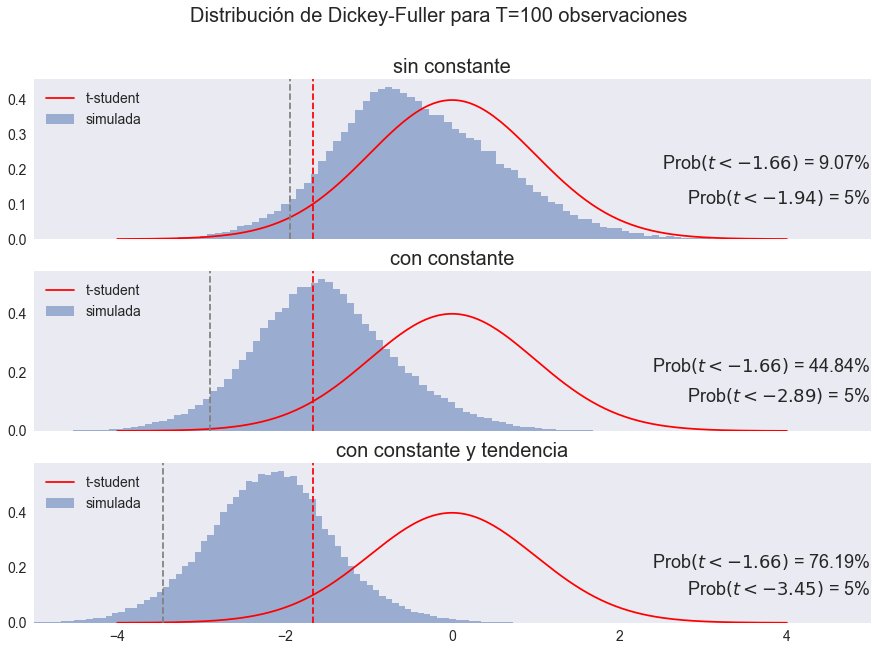

In [16]:
def plot_df(ax, data, titulo,df):
    maxtval = 5.0
    t5crit = t_Student.isf(0.05, df)

    ff, edges = np.histogram(data, bins=100, density=True)
    center = (edges[1:] + edges[:-1])/2
    w = center[1] - center[0]

    ax.bar(center, ff, width=w, alpha=0.5)
    xvals = np.linspace(-4,4, 200)
    ax.plot(xvals, t_Student.pdf(xvals, df=99), '-r')
    ax.set(xlim=[-maxtval, maxtval], title=titulo)
    ax.legend(['t-student', 'simulada'], loc='upper left')

    # valores críticos
    df5 = data.quantile(0.05)
    ax.axvline(-t5crit, ls="--", color='red')
    ax.axvline(df5, ls="--", color='gray')

    # error tipo I
    err1 = (data < -t5crit).mean()*100
    ax.annotate(f'Prob$\\left(t < -1.66\\right)$ = {err1:.2f}%', (5,0.2), size=18, ha='right')
    ax.annotate(f'Prob$\\left(t < {df5:.2f}\\right)$ = 5%', (5,0.1), size=18, ha='right')
    ax.grid(False)


fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=[15,10], sharex=True)

plot_df(ax0, dfvalues['nc'],'sin constante',99)
plot_df(ax1, dfvalues['c'],'con constante',98)
plot_df(ax2, dfvalues['ct'],'con constante y tendencia',97)

fig.suptitle('Distribución de Dickey-Fuller para T=100 observaciones', size=20)
fig.savefig('Dickey-Fuller.pdf', bbox_inches='tight')

## Potencia de la prueba

In [17]:
df5crit = dfvalues.quantile(0.05)
df5crit

nc   -1.941179
c    -2.888385
ct   -3.452957
Name: 0.05, dtype: float64

In [18]:
def df_simulacion_power(rho=0.95, T=101):
    e = np.random.randn(T)
    y = np.zeros(T)
    for t in range(1,T):
        y[t] = rho*y[t-1] + e[t]
    
    dy = y[1:] -y[:-1]
    X = sm.add_constant(y[:-1])
    Z = np.c_[X,np.arange(T-1)]
    
    res0 = sm.OLS(dy, y[:-1], hasconst=False).fit()
    res1 = sm.OLS(dy, X, hasconst=True).fit()
    res2 = sm.OLS(dy, Z, hasconst=True).fit()
    return res0.tvalues[0], res1.tvalues[1], res2.tvalues[1]

In [19]:
df_simulacion_power()

(-1.4818651299518741, -1.6212674883474039, -1.6536045122063872)

In [20]:
N = 100_000

In [21]:
%%time
dfvaluespower = pd.DataFrame([df_simulacion_power() for _ in range(N)], columns=['nc','c','ct'])

Wall time: 1min 52s


In [22]:
def plot_df2(ax, data, spec, titulo,df):
    #maxtval = 5.0
    #t5crit = t.isf(0.05, df)

    ff, edges = np.histogram(data, bins=100, density=True)
    center = (edges[1:] + edges[:-1])/2
    w = center[1] - center[0]

    ax.bar(center, ff, width=w, alpha=0.5)
    #xvals = np.linspace(-4,4, 200)
    #ax.plot(xvals, t.pdf(xvals, df=99), '-r')
    ax.set(xlim=[-5, 2], title=titulo)
    

    # valores críticos
    df5 = df5crit[spec]
    ax.axvline(df5, ls="--", color='gray')
    ax.legend(['Valor crítico Dickey-Fuller', 'estadístico $t$ simulado'], loc='upper left')
    # error tipo II
    
    err2 = (data > df5).mean()*100
    ax.annotate(f'Prob$\\left(t > {df5:.2f}\\right)$ = {err2:.2f}%', (1.5,0.5), size=18, ha='right')
    ax.grid(False)

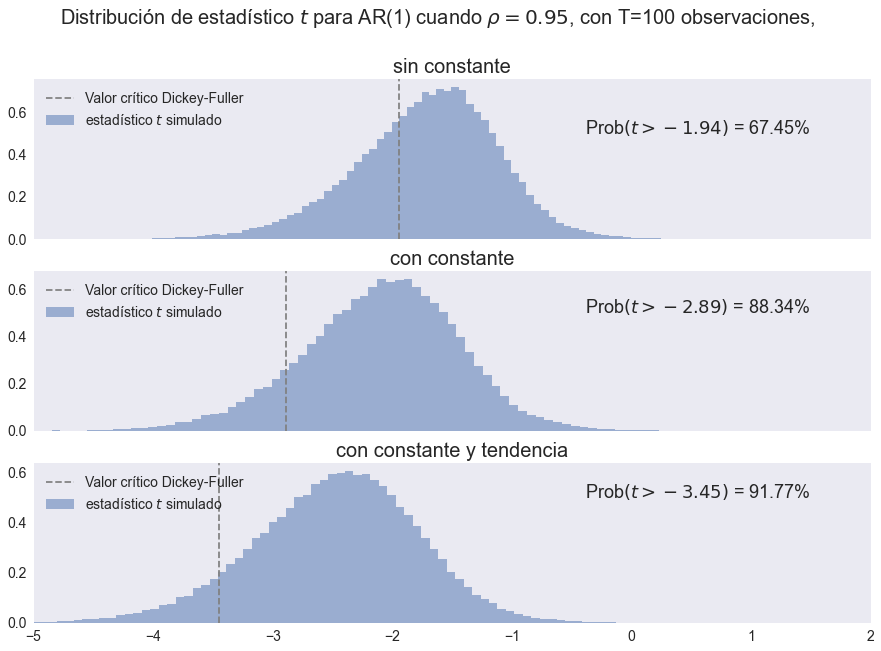

In [23]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=[15,10], sharex=True)

plot_df2(ax0, dfvaluespower['nc'],'nc','sin constante',99)
plot_df2(ax1, dfvaluespower['c'],'c','con constante',98)
plot_df2(ax2, dfvaluespower['ct'],'ct','con constante y tendencia',97)

fig.suptitle('Distribución de estadístico $t$ para AR(1) cuando $\\rho=0.95$, con T=100 observaciones, ', size=20)
fig.savefig('Dickey-Fuller-power.pdf', bbox_inches='tight')